# This file will train the models

## 0. Import required libraries

In [42]:
import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torchvision.transforms as transforms

#!pip3 install tqdm
from tqdm import tqdm
import time

## 1. Data transformation

In [43]:
# new_size contains a series of options for image size
new_size = [20,50,100,150,250,310,450]
# Change the size_choice to have a different size of images to train
size_choice = 2

# Define the transformation for the data
data_transform = transforms.Compose(
        [   
            transforms.Resize(new_size[size_choice]),
            transforms.RandomCrop(new_size[size_choice]-10, pad_if_needed=True, padding_mode="edge"),
            transforms.RandomRotation(degrees=60, expand=False),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor()
        ],
    )

validation_transform = transforms.Compose(
        [   
            transforms.Resize(new_size[size_choice]),
            transforms.ToTensor()
        ],
    )

## 2. Load the dataset

In [44]:
# Load the dataset from Dataloaders.py
from Datasets import Classification_Datasets
from torch.utils.data import DataLoader

# Path to the data
training_data_path = "./data/classification_dataset/training_images/"
training_label_path = "./data/classification_dataset/upsampled_training_labels.csv"
validation_data_path = "./data/classification_dataset/validation_images/"
validation_label_path = "./data/classification_dataset/validation_labels.csv"

# Creating the datasets
training_dataset = Classification_Datasets(training_data_path, training_label_path, data_transform)

# Resize the validation images
validation_dataset = Classification_Datasets(validation_data_path, validation_label_path, validation_transform)

# Set the batch_size and creating data loaders
batch_size = 32
train_dl = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


## 3. Instantiate the model you want to use

In [46]:
# Import the module required for the model
import ResNet
import DCN

# Instantiat the model
model = DCN.model(3, 1, 3)

TypeError: __init__() missing 2 required positional arguments: 'in_features' and 'out_features'

## 4. Set hyperparameters

In [ ]:
# Set some hyperparameters for training

# Loss function
loss_function = nn.CrossEntropyLoss()

# Evaluation function
# We can test multiple test functions at once
from sklearn.metrics import f1_score
f1 = f1_score

from sklearn.metrics import accuracy_score
acc = accuracy_score

# Learning rate
lr = 0.0001

# Number of epochs
epochs = 130

# Regularization
weight_decay = 0

## 5. Train the model

In [ ]:
# Check if the GPU available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
if torch.cuda.is_available():
    print("Running on " + torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

Running on NVIDIA Quadro M4000


In [ ]:
optimizer = optim.Adam(model.parameters(),
                        lr=lr,
                        weight_decay=weight_decay)

# Instantiate a few Python lists to track the learning curve
all_losses = []
all_accuracy = []
all_validation_accuracy = []
model.to(DEVICE)
loss_function.to(DEVICE)

for epoch in range(epochs):
    curr_losses = []
    curr_accuracy = []
    curr_validation_accuracy = []
    # Train
    with tqdm(total=len(train_dl), desc="Epoch " + str(epoch+1)) as pbar:
        model.train()
        for i, data in enumerate(train_dl, 0):
            # Update the progress bar
            pbar.update()
            # Load the current data
            imgs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)
        
            out = model.forward(imgs.float()) 
            labels = labels.float().to(device=DEVICE)
            loss = loss_function(out, labels) 
            loss.backward() 
            optimizer.step() 
            optimizer.zero_grad()

            # Save the current training information
            curr_losses.append(loss)

         # Save the current epoch training loss
        all_losses.append(sum(curr_losses)/len(curr_losses))
    
    
    # Test on training set
    with tqdm(total=len(train_dl), desc="Testing Epoch " + str(epoch+1)) as pbar:
        model.eval()
        for i, data in enumerate(train_dl, 0):
            # Update the progress bar
            pbar.update()
            # Load the current data
            imgs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)
            labels_int = labels.type(torch.int64).to(DEVICE)
            with torch.no_grad():
                prediction = model.forward(imgs.float())
                prediction = torch.sigmoid(prediction)
                prediction = (torch.max(torch.exp(prediction), 1)[1]).data.cpu().numpy()
                labels = (torch.max(torch.exp(labels_int), 1)[1]).data.cpu().numpy()

                if i == 2:
                    print(prediction)
                    print(labels)
                
                accuracy = acc(prediction, labels)

                # Save the current training information
                curr_accuracy.append(accuracy)
        # Save the current epoch training accuracy
        all_accuracy.append(sum(curr_accuracy)/len(curr_accuracy))
    

    # Test on validation set
    with tqdm(total=len(validation_dl), desc="Testing Epoch " + str(epoch+1)) as pbar:
        model.eval()
        for i, data in enumerate(validation_dl, 0):
            # Update the progress bar
            pbar.update()
            # Load the current data
            imgs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)
            labels_int = labels.type(torch.int64).to(DEVICE)
            with torch.no_grad():
                prediction = model.forward(imgs.float())
                prediction = torch.sigmoid(prediction)
                prediction = (torch.max(torch.exp(prediction), 1)[1]).data.cpu().numpy()
                labels = (torch.max(torch.exp(labels_int), 1)[1]).data.cpu().numpy()
                
                if i == 2:
                    print(prediction)
                    print(labels)
                
                accuracy = acc(prediction, labels)

                # Save the current training information
                curr_validation_accuracy.append(accuracy)

        all_validation_accuracy.append(sum(curr_validation_accuracy)/len(curr_validation_accuracy))
    
    
    print("Training Loss: %f \t Training Accuracy: %f \t Validation Accuracy: %f" %(all_losses[epoch], all_accuracy[epoch], all_validation_accuracy[epoch]))
    
# Save the model
torch.save(model.state_dict(), "./models/resnet")


Epoch 1:   0%|          | 1/329 [00:00<02:09,  2.54it/s]


RuntimeError: The size of tensor a (1152) must match the size of tensor b (43808) at non-singleton dimension 2

## 6. Test the model

## 7. Plot the result

In [ ]:
all_losses
all_accuracy
all_validation_accuracy

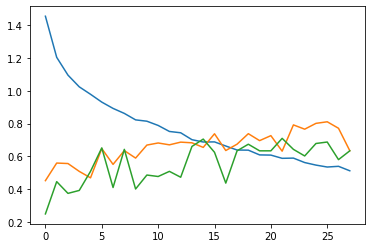

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(all_losses)), all_losses)
plt.plot(range(len(all_losses)), all_accuracy)
plt.plot(range(len(all_losses)), all_validation_accuracy)